In [ ]:
IDENTIFIER = "haydn-op1"
NUM = 4

import json
import networkx as nx
import pandas as pd
from dwave.system import DWaveSampler, FixedEmbeddingComposite

from plots import plotCSV
from qubo import createBQM
from samples import firstValid, totalEntropy


picklePath = f"../Pickles/{IDENTIFIER}/{IDENTIFIER}_"
numPath = f"../Pickles/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"
dataPath = f"../Data/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"

phrases = pd.read_csv(picklePath + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(picklePath + "graph.graphml")
instruments = json.load(open(numPath + "instruments.json"))
embedding = json.load(open(numPath + "embedding.json", "r"))
qa = FixedEmbeddingComposite(DWaveSampler(), embedding)

In [ ]:
def recordChainStrength(strengthRange, bqm, filepath: str):
    
    file = pd.DataFrame()
    reads = 1000

    for s in strengthRange:
        sampleset = qa.sample(bqm, num_reads=reads, chain_strength=s, label=f"{IDENTIFIER}_{NUM}_cs={s}")
        sample = firstValid(sampleset)

        new_row = pd.DataFrame({
            "Chain strength": [sampleset.info["embedding_context"]["chain_strength"]],
            "Total reads": [reads],
            "Time": [sampleset.info["timing"]["qpu_access_time"]],
            "Chain break fraction": [sample.chain_break_fraction],
            "Lowest energy": [bqm.energy(sample.sample)],
            "Total entropy": [totalEntropy(sample, G)]
            })
    
        print(f"Chain strength {s} recorded!")
        file = pd.concat([file, new_row])

    file.to_csv(filepath, index=False, mode="a", header=False)


chainStrengths = range(12,42)
bqm = createBQM(G, phrases, instruments, 6, 6, 1)
recordChainStrength(chainStrengths, bqm, dataPath+"chain-strength.csv")

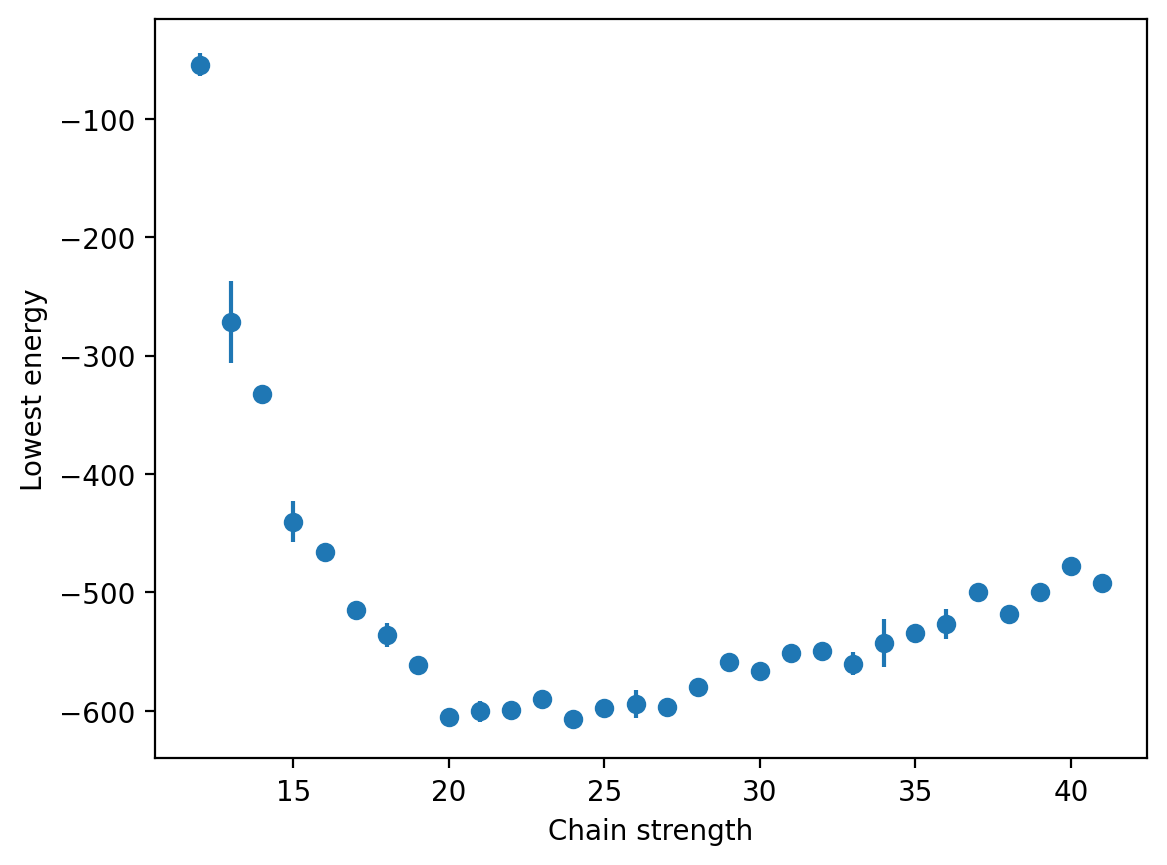

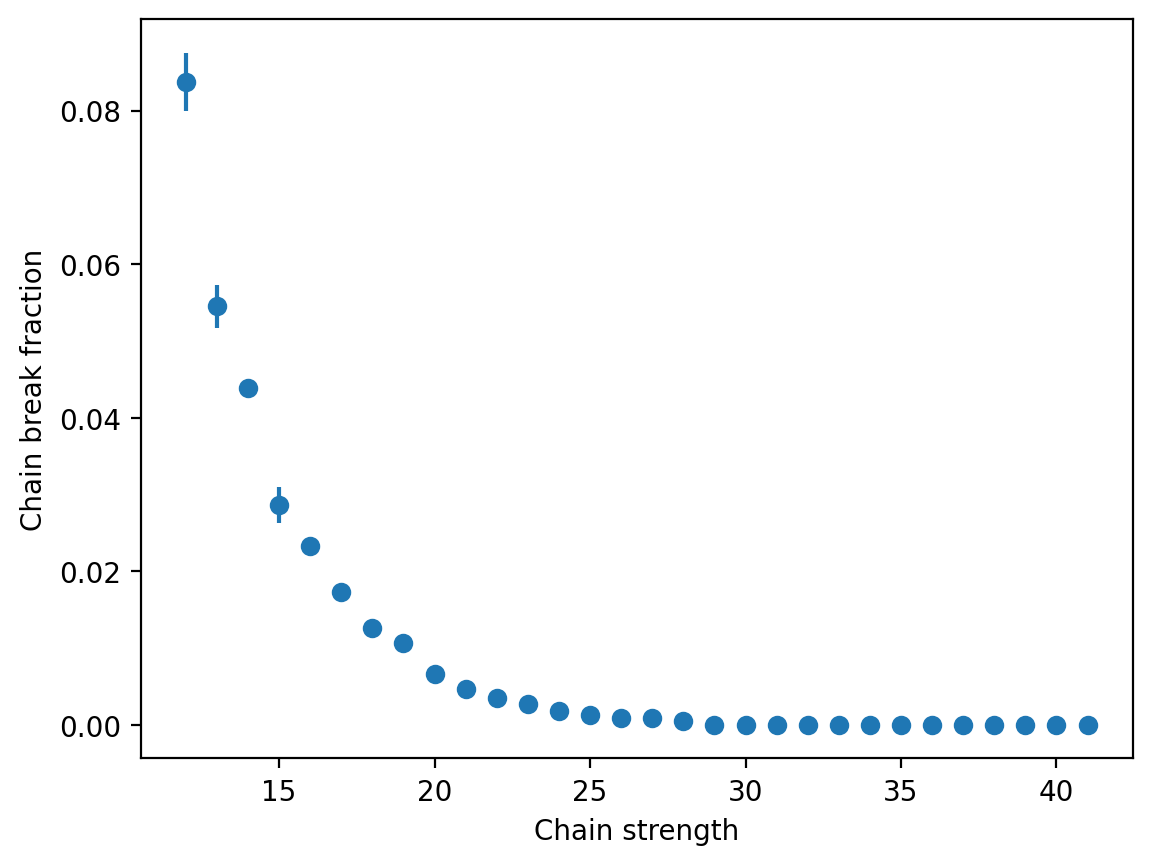

In [ ]:
plotCSV(dataPath+"chain-strength.csv", "Chain strength", "Lowest energy")

# ~25 optimal???
# chain_break_method=chain_breaks.discard?????
# Don't care about chain breaks, only valid solutions